In [22]:
import pandas as pd
import numpy as np
import os
import mido

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
train_midi_path = "./Challenge_DataSet/PS1/"
test_midi_path = "./Challenge_DataSet/PS2/"

In [13]:
print(os.listdir(train_midi_path))
print(os.listdir(test_midi_path))

['.DS_Store', 'Beethoven', 'Schubert', 'Bach', 'Brahms']
['0.8014751784512073_adj.mid', '0.981087291054314_adj.mid', '0.5807329043589801_adj.mid', '0.23120017256495873_adj.mid', '0.033313986422223163_adj.mid', '0.3559970176888735_adj.mid', '0.3264565808984162_adj.mid', '0.905499891236923_adj.mid', '0.10250888365879718_adj.mid', '0.48367685897240176_adj.mid', '0.549470161204349_adj.mid', '0.33695573887576447_adj.mid', '0.7491289879531658_adj.mid', '0.337517805339117_adj.mid', '0.07186746659481313_adj.mid', '0.09167358800381353_adj.mid', '0.539512676743813_adj.mid', '0.26551079719260606_adj.mid', '0.647959423719129_adj.mid', '0.047574444458241216_adj.mid', '0.10222964826466285_adj.mid', '0.22047111832936942_adj.mid', '0.1755252422917658_adj.mid', '0.36321860283443286_adj.mid', '0.21198476749665085_adj.mid', '0.06402123326764841_adj.mid', '0.3620067189216978_adj.mid', '0.9511403301279795_adj.mid', '0.1960551158929671_adj.mid', '0.21901852969811753_adj.mid', '0.10630249969742178_adj.mid', 

In [14]:
# example file
train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid"

'./Challenge_DataSet/PS1/Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid'

## Data Collection and Processing from ChatGPT

In [15]:
def extract_features_from_midi(file_path):
    midi = mido.MidiFile(file_path)
    note_counts = [0] * 128  # MIDI notes range from 0 to 127
    
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_counts[msg.note] += 1
    
    return note_counts

In [18]:
# features=extract_features_from_midi(train_midi_path+"Bach/Cello Suite 3_BWV1009_2217_cs3-1pre.mid")

In [19]:
def load_dataset(directory):
    features = []
    labels = []
    for composer_dir in os.listdir(directory):
        composer_path = os.path.join(directory, composer_dir)
        if os.path.isdir(composer_path):
            for file_name in os.listdir(composer_path):
                if file_name.endswith('.mid'):
                    file_path = os.path.join(composer_path, file_name)
                    features.append(extract_features_from_midi(file_path))
                    labels.append(composer_dir)
    return features, labels

In [24]:
features, labels = load_dataset(train_midi_path)

In [45]:
# Normalize the values in each row to be between 0 and 1
normalized_features = (features - np.min(features, axis=1, keepdims=True)) / (np.max(features, axis=1, keepdims=True) - np.min(features, axis=1, keepdims=True))

In [46]:
normalized_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## EDA from Bart

In [47]:
def create_dataframe(features, labels):
    # Convert to pandas DataFrame
    feature_columns = [f'Note_{i}' for i in range(128)]
    df = pd.DataFrame(features, columns=feature_columns)
    df['Composer'] = labels
    return df

df = create_dataframe(normalized_features, labels)
df.head()

,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,Note_7,Note_8,Note_9,...,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127,Composer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Beethoven


In [58]:
composer_avg = df.groupby(by='Composer').mean()
composer_avg.describe()

,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,Note_7,Note_8,Note_9,...,Note_118,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127
count,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
composer_avg.head()

,Note_0,Note_1,Note_2,Note_3,Note_4,Note_5,Note_6,Note_7,Note_8,Note_9,...,Note_118,Note_119,Note_120,Note_121,Note_122,Note_123,Note_124,Note_125,Note_126,Note_127
Composer,,,,,,,,,,,,,,,,,,,,,
Bach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Beethoven,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brahms,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Schubert,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


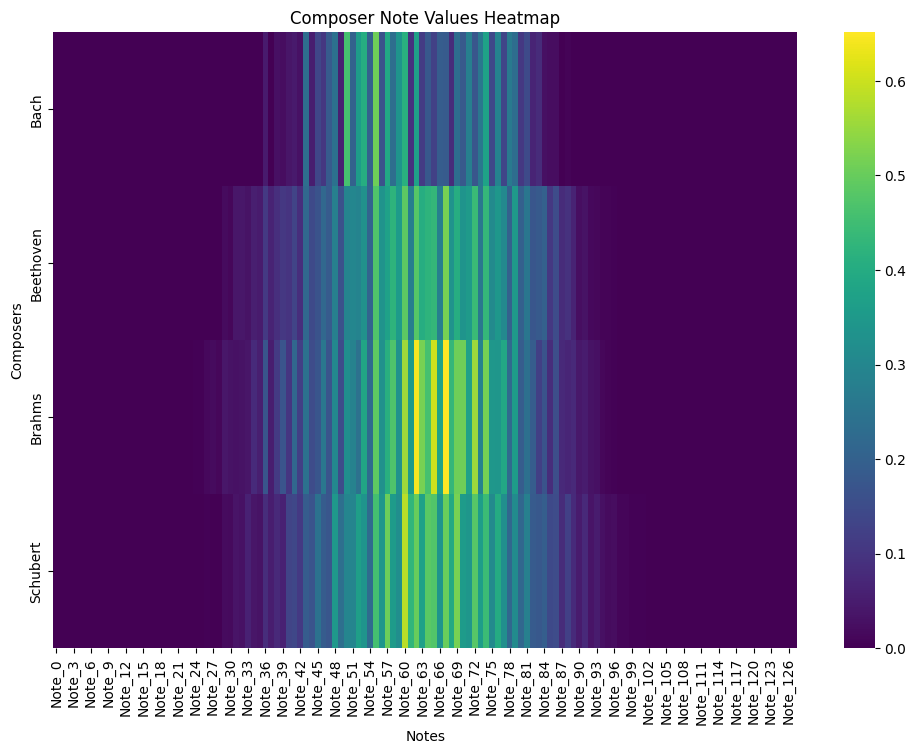

In [61]:
# Generate the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(composer_avg, cmap='viridis', cbar=True)

# Display the plot
plt.title('Composer Note Values Heatmap')
plt.xlabel('Notes')
plt.ylabel('Composers')
plt.show()

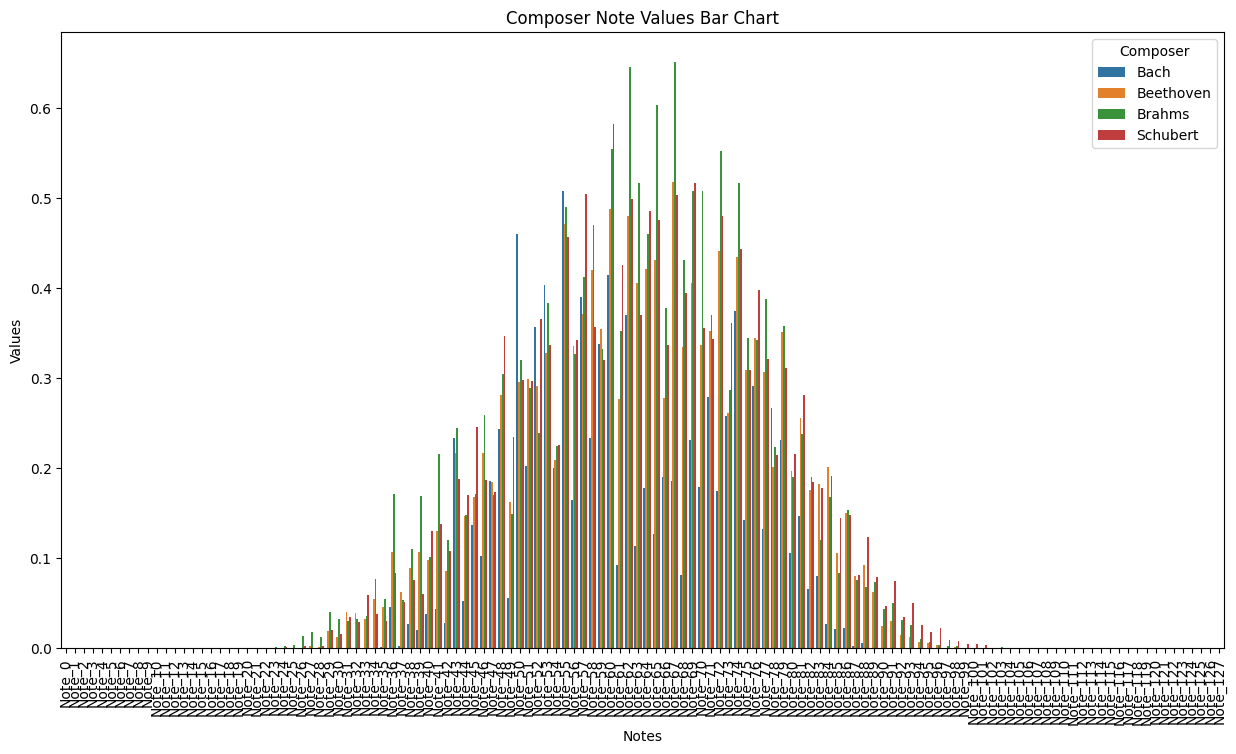

In [64]:
# Transform the DataFrame into a long format
df_long = pd.melt(composer_avg.reset_index(), id_vars=['Composer'], var_name='Note', value_name='Value')

# Plot the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x='Note', y='Value', hue='Composer', data=df_long)

# Customize the plot
plt.title('Composer Note Values Bar Chart')
plt.xlabel('Notes')
plt.ylabel('Values')
plt.legend(title='Composer')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed for better readability

# Display the plot
plt.show()

## Feature engineer/Bart

* dump csv into chatgpt for data analysis

## Train Classifier from ChatGPT

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
features, labels = load_dataset('path_to_midi_files')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


## Inference

In [ ]:
def predict_composer(file_path, classifier):
    features = extract_features_from_midi(file_path)
    prediction = classifier.predict([features])
    return prediction[0]

# Example usage
new_midi_file = 'new_piece.mid'
composer = predict_composer(new_midi_file, clf)
print(f"The predicted composer is: {composer}")
